In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import numpy as np
from google.colab import drive
from torchvision.ops import nms
import subprocess
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Custom transform for COCO dataset
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [8]:
# Load COCO dataset
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

In [17]:
# Load training and validation datasets
train_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/minorproject/Dataset/train",
    ann_file="/content/drive/MyDrive/minorproject/Dataset/train/annotations/train_annotations_coco.json"
)

val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/minorproject/Dataset/valid",
    ann_file="/content/drive/MyDrive/minorproject/Dataset/valid/annotations/valid_annotations_coco.json"
)

loading annotations into memory...
Done (t=1.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [18]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=7, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=7, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [19]:
# Load Faster R-CNN model
def get_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
# Initialize Faster R-CNN model
num_classes = 7  # Number of classes in your dataset
fasterrcnn_model = get_fasterrcnn_model(num_classes).to(device)

In [21]:
# Optimizer and learning rate scheduler
params = [p for p in fasterrcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [22]:
# Training function for Faster R-CNN
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                bbox = obj["bbox"]
                x, y, w, h = bbox
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])
                    labels.append(obj["category_id"])
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])
        if not processed_targets:
            continue
        images = valid_images
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")


In [23]:
# Train Faster R-CNN
num_epochs = 50
for epoch in range(num_epochs):
    train_one_epoch(fasterrcnn_model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    model_path = f"/content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(fasterrcnn_model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

Epoch [0] Loss: 0.4379
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 0.4251
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 0.2929
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 0.1334
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 0.1732
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_5.pth
Epoch [5] Loss: 0.2187
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_6.pth
Epoch [6] Loss: 0.0827
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_7.pth
Epoch [7] Loss: 0.1152
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_8.pth
Epoch [8] Loss: 0.1401
Model saved: /content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_9.pth
Epoch [9] Loss: 0.1196
Model saved: /content/drive/MyDrive/minor

In [24]:
# Load trained Faster R-CNN model
fasterrcnn_model.load_state_dict(torch.load("/content/drive/MyDrive/minorproject/fasterrcnn_resnet50_epoch_50.pth", map_location=device))
fasterrcnn_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [25]:
# Class labels
COCO_CLASSES = {0:"background",1: "carrot", 2: "chilli", 3: "cauliflower", 4: "tomato", 5: "onion", 6: "potato"}

In [26]:
# Prepare image for inference
def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    return image_tensor

In [27]:
# Replace this with the actual class IDs and names used in your YOLO training
YOLO_CLASSES = {
    0: "carrot",  # Example: YOLO class ID 0 corresponds to "carrot"
    1: "chilli",  # Example: YOLO class ID 1 corresponds to "chilli"
    2: "cauliflower",  # Example: YOLO class ID 2 corresponds to "cauliflower"
    3: "tomato",  # Example: YOLO class ID 3 corresponds to "tomato"
    4: "onion",  # Example: YOLO class ID 4 corresponds to "onion"
    5: "potato",  # Example: YOLO class ID 5 corresponds to "potato"
}

In [46]:
# Run YOLO training, validation, and prediction
def run_yolo_commands():
    # Install ultralytics
    subprocess.run(["pip", "install", "ultralytics"])

    # YOLO predict on a sample image
    subprocess.run(["yolo", "predict", "model=/content/drive/MyDrive/minorproject_yolo/yolov8n.pt", "source=https://ultralytics.com/images/bus.jpg"])

    # YOLO train
    subprocess.run(["yolo", "task=detect", "mode=train", "model=/content/drive/MyDrive/minorproject_yolo/yolov8s.pt", "data=/content/drive/MyDrive/minorproject_yolo/data.yaml", "epochs=25", "imgsz=640", "plots=True"])

    # YOLO validate
    subprocess.run(["yolo", "task=detect", "mode=val", "model=/content/drive/MyDrive/minorproject_yolo/runs/detect/train19/weights/best.pt", "data=/content/drive/MyDrive/minorproject_yolo/data.yaml"])

    # YOLO predict on custom image
    subprocess.run(["yolo", "task=detect", "mode=predict", "model=/content/drive/MyDrive/minorproject_yolo/runs/detect/train19/weights/best.pt", "conf=0.1", "source=/content/drive/MyDrive/minorproject/images.jpg"])

# Run YOLO commands
run_yolo_commands()

In [55]:
# Run YOLO predictions using ultralytics Python API
def run_yolo_predictions(image_path):
    # Load YOLO model
    yolo_model = YOLO("/content/drive/MyDrive/minorproject_yolo/runs/detect/train19/weights/best.pt")

    # Run prediction
    results = yolo_model.predict(source=image_path, conf=0.1)

    # Extract bounding boxes, scores, and labels
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes in [x_min, y_min, x_max, y_max] format
    scores = results[0].boxes.conf.cpu().numpy()  # Confidence scores
    labels = results[0].boxes.cls.cpu().numpy()  # Class labels

    # Map YOLO class IDs to class names
    labels = [YOLO_CLASSES[int(label)] for label in labels]

    return boxes, scores, labels

In [56]:
# Define a reverse mapping from class names to class IDs
CLASS_NAME_TO_ID = {v: k for k, v in COCO_CLASSES.items()}

# NMS-based Fusion
def nms_fusion(fasterrcnn_predictions, yolo_predictions, iou_threshold=0.5):
    fasterrcnn_boxes = fasterrcnn_predictions[0]['boxes'].cpu().numpy()
    fasterrcnn_scores = fasterrcnn_predictions[0]['scores'].cpu().numpy()
    fasterrcnn_labels = fasterrcnn_predictions[0]['labels'].cpu().numpy()

    yolo_boxes, yolo_scores, yolo_labels = yolo_predictions

    # Convert YOLO class names to class IDs
    yolo_label_ids = [CLASS_NAME_TO_ID[label] for label in yolo_labels]

    combined_boxes = np.vstack([fasterrcnn_boxes, yolo_boxes])
    combined_scores = np.hstack([fasterrcnn_scores, yolo_scores])
    combined_labels = np.hstack([fasterrcnn_labels, yolo_label_ids])

    combined_boxes = torch.tensor(combined_boxes, dtype=torch.float32)
    combined_scores = torch.tensor(combined_scores, dtype=torch.float32)

    keep_indices = nms(combined_boxes, combined_scores, iou_threshold)
    final_boxes = combined_boxes[keep_indices].numpy()
    final_scores = combined_scores[keep_indices].numpy()
    final_labels = combined_labels[keep_indices]

    return final_boxes, final_scores, final_labels

In [57]:
# Display detected items and unique items for all models
def display_detected_items(fasterrcnn_labels, yolo_labels, final_labels):
    # Get detected items for each model
    fasterrcnn_items = [COCO_CLASSES[label] for label in fasterrcnn_labels]
    yolo_items = yolo_labels  # YOLO labels are already class names
    ensemble_items = [COCO_CLASSES[label] for label in final_labels]

    # Get unique items across all models
    all_items = fasterrcnn_items + yolo_items + ensemble_items

    # Display detected items
    print("Detected Items in Faster R-CNN:", fasterrcnn_items)
    print("Detected Items in YOLO:", yolo_items)
    print("Detected Items in Ensemble Model:", ensemble_items)

# Visualize predictions for Faster R-CNN and Ensemble Model
def visualize_predictions(image_path, boxes, scores, labels, title):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box, score, label in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"{COCO_CLASSES[label]} {score:.2f}", color='r')
    ax.set_title(title)
    plt.show()

# Visualize predictions for YOLO
def visualize_predictions_yolo(image_path, boxes, scores, labels, title):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box, score, label in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"{label} {score:.2f}", color='b')
    ax.set_title(title)
    plt.show()

In [58]:
# Run inference and ensemble
image_path = "/content/drive/MyDrive/minorproject/images.jpg"
image_tensor = prepare_image(image_path)

In [59]:
# Faster R-CNN predictions
with torch.no_grad():
    fasterrcnn_predictions = fasterrcnn_model(image_tensor)
fasterrcnn_boxes = fasterrcnn_predictions[0]['boxes'].cpu().numpy()
fasterrcnn_scores = fasterrcnn_predictions[0]['scores'].cpu().numpy()
fasterrcnn_labels = fasterrcnn_predictions[0]['labels'].cpu().numpy()

In [60]:
# YOLO predictions
yolo_boxes, yolo_scores, yolo_labels = run_yolo_predictions(image_path)
print("Detected Items in YOLO:", yolo_labels)
# Ensemble predictions
final_boxes, final_scores, final_labels = nms_fusion(fasterrcnn_predictions, (yolo_boxes, yolo_scores, yolo_labels))


image 1/1 /content/drive/MyDrive/minorproject/images.jpg: 416x640 1 cauliflower, 3 tomatos, 40.7ms
Speed: 2.3ms preprocess, 40.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
Detected Items in YOLO: ['cauliflower', 'tomato', 'tomato', 'tomato']


In [61]:
# Display detected items and unique items
display_detected_items(fasterrcnn_labels, yolo_labels, final_labels)

Detected Items in Faster R-CNN: ['tomato', 'tomato', 'cauliflower', 'tomato', 'tomato', 'onion', 'onion', 'potato', 'onion']
Detected Items in YOLO: ['cauliflower', 'tomato', 'tomato', 'tomato']
Detected Items in Ensemble Model: ['tomato', 'tomato', 'cauliflower', 'tomato', 'tomato']


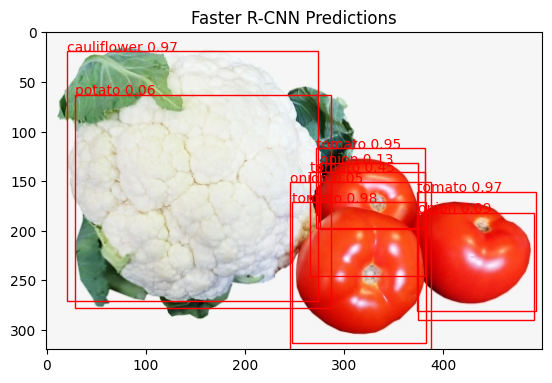

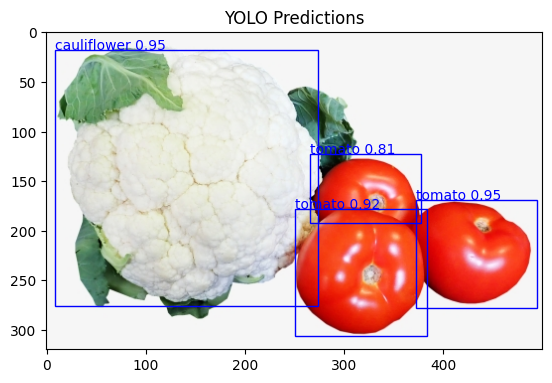

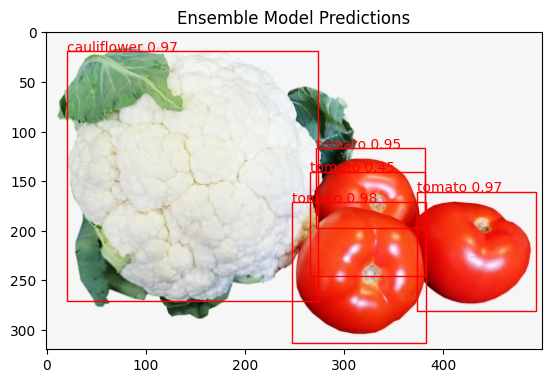

In [62]:
# Visualize predictions
visualize_predictions(image_path, fasterrcnn_boxes, fasterrcnn_scores, fasterrcnn_labels, "Faster R-CNN Predictions")
visualize_predictions_yolo(image_path, yolo_boxes, yolo_scores, yolo_labels, "YOLO Predictions")
visualize_predictions(image_path, final_boxes, final_scores, final_labels, "Ensemble Model Predictions")

In [63]:
ensemble_items = [COCO_CLASSES[label] for label in final_labels]
unique_items = list(dict.fromkeys(ensemble_items))
print(unique_items)


['tomato', 'cauliflower']


In [64]:
import pickle
from collections import namedtuple

In [65]:
# Define a lightweight class to store the ensemble model components
EnsembleModel = namedtuple('EnsembleModel', ['fasterrcnn_model', 'yolo_model', 'class_mappings'])


In [66]:
# Create the ensemble model object
ensemble_model = EnsembleModel(
    fasterrcnn_model=fasterrcnn_model,
    yolo_model=YOLO("/content/drive/MyDrive/minorproject_yolo/runs/detect/train19/weights/best.pt"),
    class_mappings={
        'COCO_CLASSES': COCO_CLASSES,
        'YOLO_CLASSES': YOLO_CLASSES,
        'CLASS_NAME_TO_ID': CLASS_NAME_TO_ID
    }
)

In [67]:
# Save the ensemble model as a pickle file
with open('/content/drive/MyDrive/minorproject/ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

print("Ensemble model saved as pickle file!")

Ensemble model saved as pickle file!
